# In Depth: Linear Regression

Linear regression models are a good starting point for regression tasks. Such models are popular because they can be fit very quickly, and are very interpretable.

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from mpl_toolkits import mplot3d
import numpy as np
plt.rcParams['figure.figsize'] = (14, 8)

# Simple Linear Regression

A straight-line fit is a model of the form 
$$
y = ax+b
$$
where $a$ is the _slope_ and $b$ is the _intercept_.

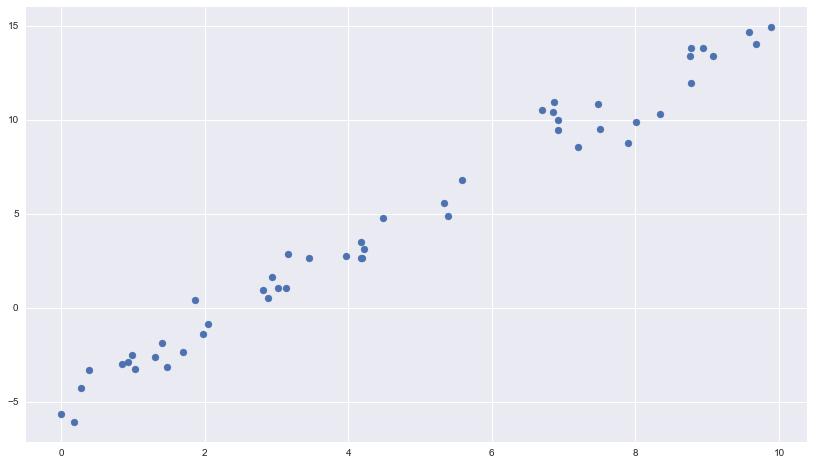

In [35]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

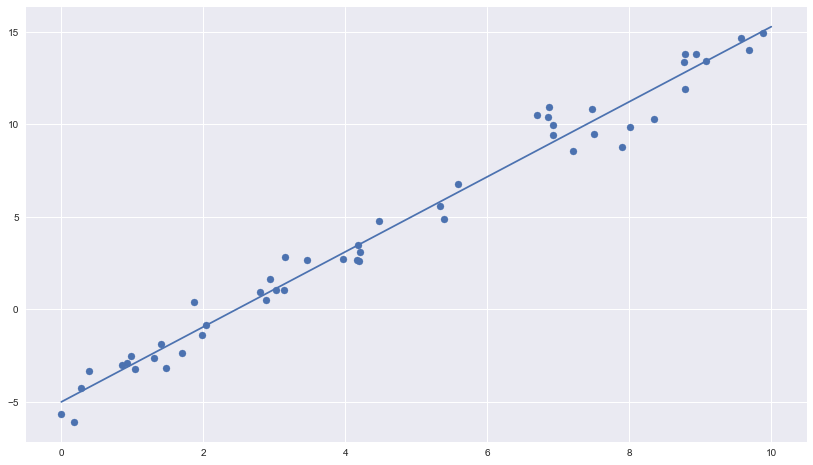

In [36]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

In [37]:
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:     2.0272088103606953
Model intercept: -4.998577085553204


The LinearRegression estimator can find an hyperplane in higher dimensions too.

4.999999999999995
[ 1.5 -2. ]


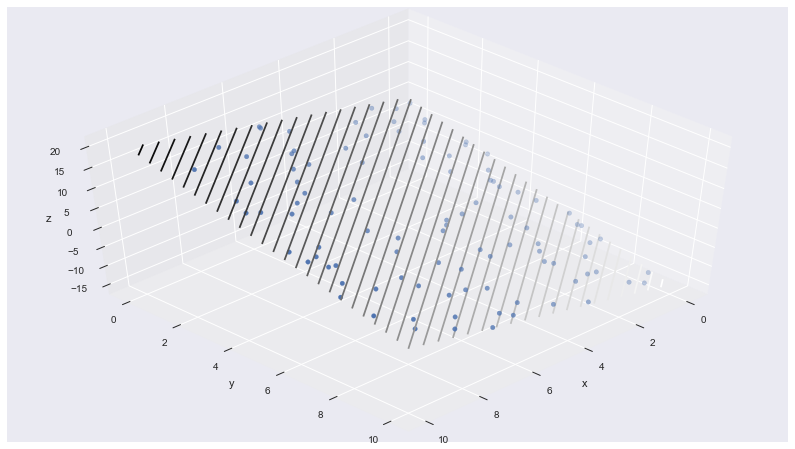

In [38]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 2)
z = 5 + np.dot(X, [1.5, -2.])

model.fit(X, z)
print(model.intercept_)
print(model.coef_)

Xfit, Yfit = np.meshgrid(np.linspace(0, 10, 20), np.linspace(0, 10, 20))
zfit = model.predict(np.vstack((Xfit.ravel(), Yfit.ravel())).T)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], z);
ax.contour3D(Xfit, Yfit, zfit.reshape(Xfit.shape), 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
ax.view_init(50, 45)

# Basis Function Regression

One trick you can use to adapt linear regression to nonlinear relationships between variables is to transform the data according to _basis functions_.
Basis functions can be :
- Polynomial
- Gaussian 
- Sin/Cos

The idea is to take our multidimensional linear model:
$$
y = a_0 + a_1x_1 + a_2x_2 + ~...
$$

and build the x1,x2,x3, and so on, from our single-dimensional input x. That is, we let $x_n=f_n(x)$, where $f_n()$ is some _basis function_ that transforms our data.

For example, if $f_n(x) = x^n$ our model becomes a polynomial regression: 
$$
y = a_0 + a_1x + a_2x^2 + ~...
$$

Notice that this is still a linear model—the linearity refers to the fact that the coefficients an never multiply or divide each other.

## Polynomial basis functions

Builtin in the `PolynomialFeatures` transformer.

In [39]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

We see here that the transformer has converted our one-dimensional array into a three-dimensional array by taking the exponent of each value.

In [40]:
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

poly_model = PolynomialRegression(degree=7)

With this transform in place, we can use the __linear model__ to fit __much more complicated relationships between x and y__. For example, here is a sine wave with noise:

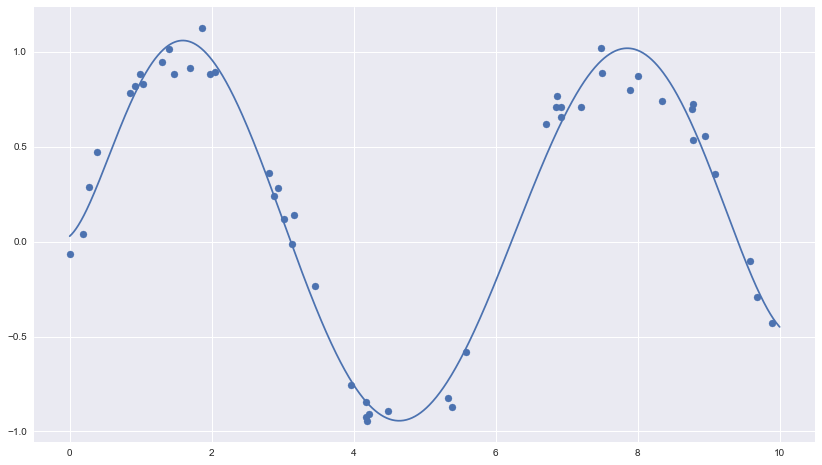

In [41]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50) # shape (50,)
y = np.sin(x) + 0.1 * rng.randn(50) # shape (50,)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis]) # xfit = np.linspace(0,10,60)

plt.scatter(x, y)
plt.plot(xfit, yfit);

## Gaussian basis functions

The idea is to fit a model as a sum of Gaussian bases.

![](figures/05.06-gaussian-basis.png)

The shaded regions in the plot are the scaled basis functions, and when added together they reproduce the smooth curve through the data.

In [42]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
        
    def fit(self, X, y=None):
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
    
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_, self.width_, axis=1)
    
    @staticmethod
    def _gauss_basis(X, centers, width, axis):
        arg = (X - centers) / width # (x - µ) / sigma
        return np.exp(-0.5 * np.sum(arg ** 2, axis))    

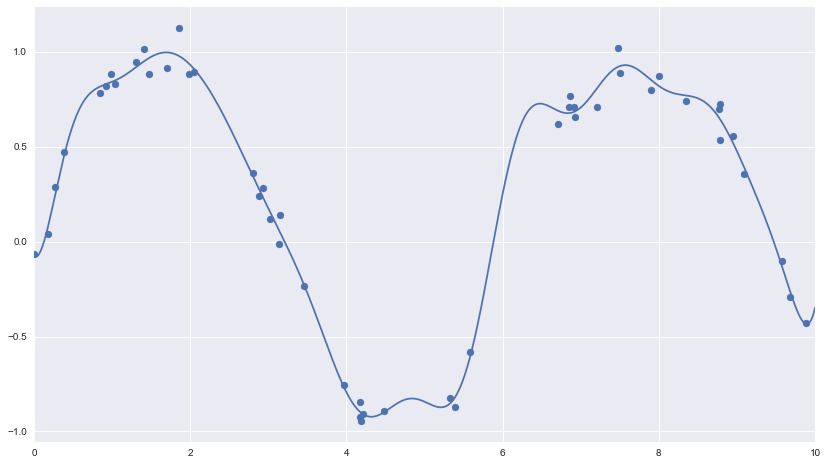

In [43]:
   
gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);

# Regularization

The introduction of basis functions into our linear regression makes the model much more flexible, but it also can very quickly lead to __over-fitting__.

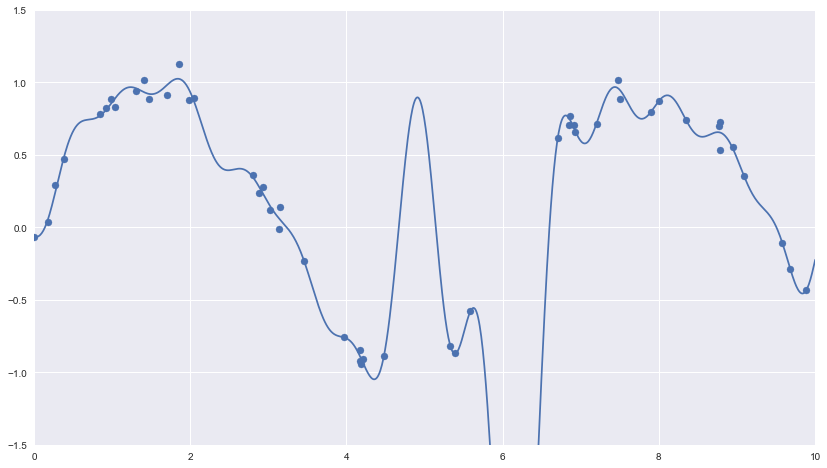

In [44]:
model = make_pipeline(GaussianFeatures(30), # 30 is too much
                      LinearRegression())
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);

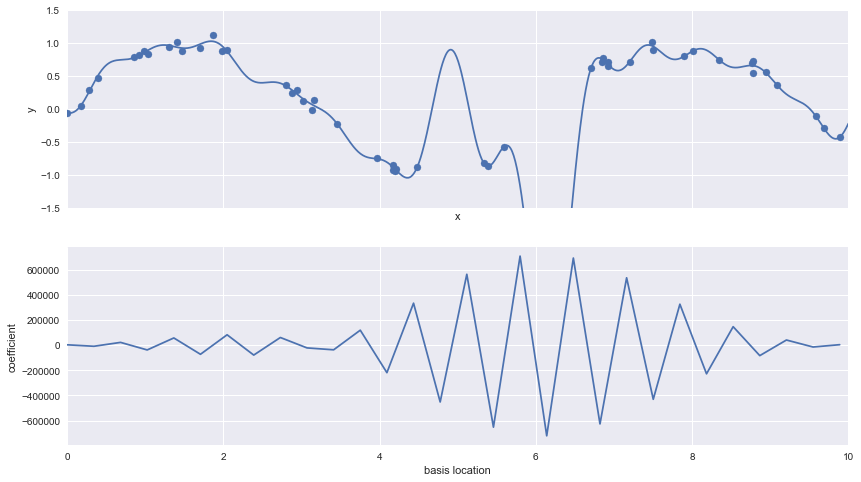

In [45]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)

    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
              xlim=(0, 10))
    
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

The lower panel of this figure shows the amplitude of the basis function at each location. This is __typical over-fitting behavior__ when basis functions overlap: __the coefficients of adjacent basis functions blow up and cancel each other out__.


We could limit such spikes expliticly in the model by penalizing large values of the model parameters. 

## Ridge regression ($L_2$ Regularization)

Penalizing the sum of squares (2-norms) of the model coefficients.
$$
P = \alpha\sum_{n=1}^N \theta_n^2
$$

$\alpha$ controls the strength of the penalty.
This is built-in in Scikit-learn in the `Ridge` estimator.

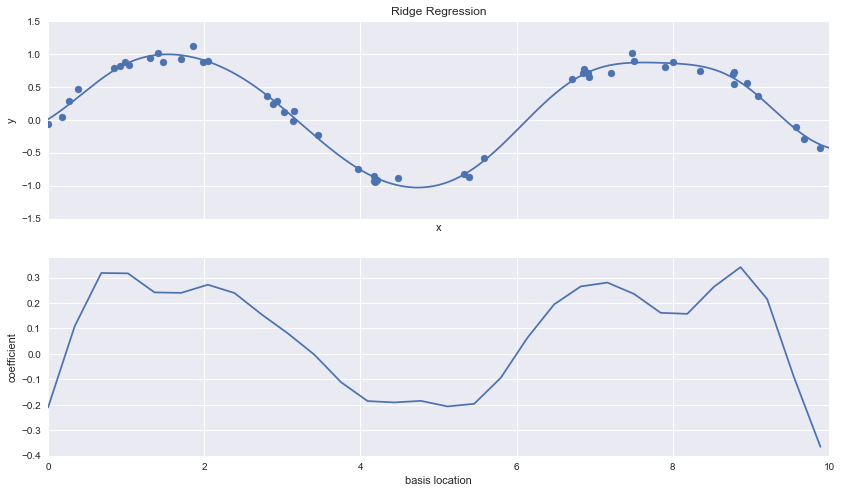

In [46]:
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression')

One advantage of ridge regression in particular is that it can be computed very efficiently

## Lasso regression ($L_1$ regularization)

$$
P = \alpha\sum_{n=1}^N |\theta_n|
$$
Due to geometric reasons lasso regression tends to favor sparse models where possible: that is, it preferentially sets model coefficients to exactly zero.

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


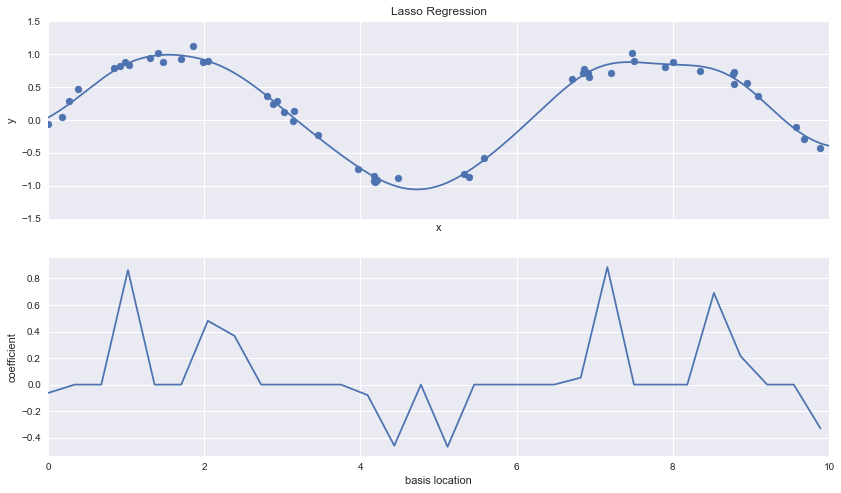

In [47]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))
basis_plot(model, title='Lasso Regression')

# Example: Predicting Bicycle Traffic

Predict the number of bicycle trips across Seattle's Fremont Bridge based on weather, season, and other factors. 

We will:
- perform a simple linear regression to relate weather and other information to bicycle counts

In [48]:
import pandas as pd
counts = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('data/BicycleWeather.csv', index_col='DATE', parse_dates=True)

In [49]:
print(counts.index)
counts.describe()

DatetimeIndex(['2012-10-03 00:00:00', '2012-10-03 01:00:00',
               '2012-10-03 02:00:00', '2012-10-03 03:00:00',
               '2012-10-03 04:00:00', '2012-10-03 05:00:00',
               '2012-10-03 06:00:00', '2012-10-03 07:00:00',
               '2012-10-03 08:00:00', '2012-10-03 09:00:00',
               ...
               '2018-11-30 14:00:00', '2018-11-30 15:00:00',
               '2018-11-30 16:00:00', '2018-11-30 17:00:00',
               '2018-11-30 18:00:00', '2018-11-30 19:00:00',
               '2018-11-30 20:00:00', '2018-11-30 21:00:00',
               '2018-11-30 22:00:00', '2018-11-30 23:00:00'],
              dtype='datetime64[ns]', name='Date', length=54000, freq=None)


,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
count,53991.000000,53991.000000
mean,57.162879,54.416569
std,82.455352,71.429187
min,0.000000,0.000000
25%,7.000000,7.000000
50%,29.000000,30.000000
75%,70.000000,72.000000
max,717.000000,698.000000


In [50]:
print(weather.index)
weather.describe()

DatetimeIndex(['2012-10-03', '2012-10-04', '2012-10-05', '2012-10-06',
               '2012-10-07', '2012-10-08', '2012-10-09', '2012-10-10',
               '2012-10-11', '2012-10-12',
               ...
               '2018-11-21', '2018-11-22', '2018-11-23', '2018-11-24',
               '2018-11-25', '2018-11-26', '2018-11-27', '2018-11-28',
               '2018-11-29', '2018-11-30'],
              dtype='datetime64[ns]', name='DATE', length=2250, freq=None)


,PRCP,SNOW,TAVG,TMAX,TMIN
count,2250.000000,2249.000000,2040.000000,2250.00000,2250.000000
mean,3.055600,0.232992,12.636569,16.60920,8.341111
std,6.774071,3.969295,5.929637,7.43265,4.982721
min,0.000000,0.000000,-4.400000,-1.60000,-7.100000
25%,0.000000,0.000000,8.300000,11.10000,5.000000
50%,0.000000,0.000000,12.400000,15.60000,8.300000
75%,2.800000,0.000000,17.200000,22.20000,12.200000
max,55.900000,130.000000,27.600000,35.60000,20.600000


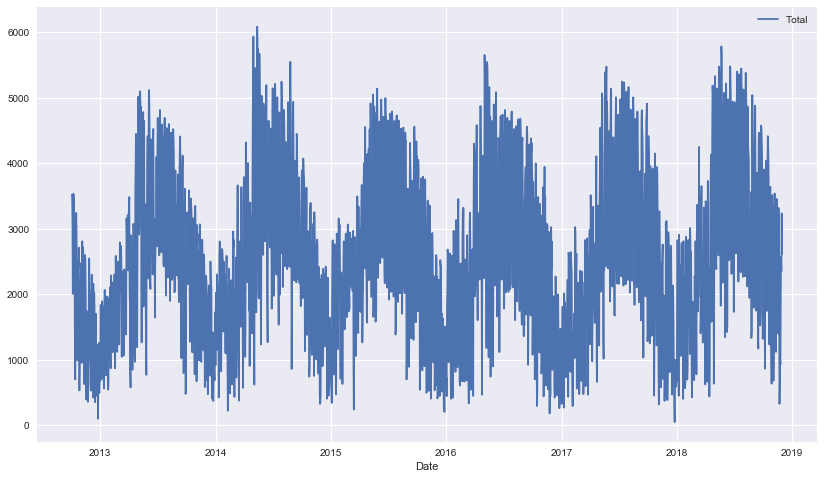

In [67]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove others columns
daily.plot()

In [52]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i, day in enumerate(days):
    daily[day] = (daily.index.dayofweek == i).astype(float)

In [53]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

(8, 17)

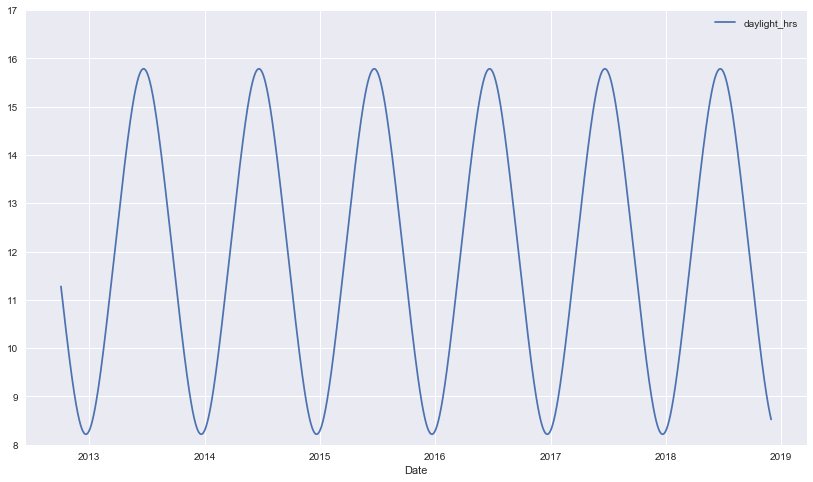

In [54]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

In [55]:
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'dry day', 'Temp (C)']])

In [56]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [57]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,dry day,Temp (C),annual
Date,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,1,13.35,0.000000
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,1,13.60,0.002740
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,1,15.30,0.005479
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,1,15.85,0.008219
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,1,15.85,0.010959


With this in place, we can __choose the columns to use__, and __fit a linear regression model__ to our data.

In [58]:
# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

Xtrain, ytrain = X[:'2017-12-31'], y[:'2017-12-31']
Xtest, ytest = X['2018-01-01':'2018-10-31'], y['2018-01-01':'2018-10-31']

model = LinearRegression(fit_intercept=False)
model.fit(Xtrain, ytrain)
ypred = pd.Series(model.predict(Xtest), index=Xtest.index)

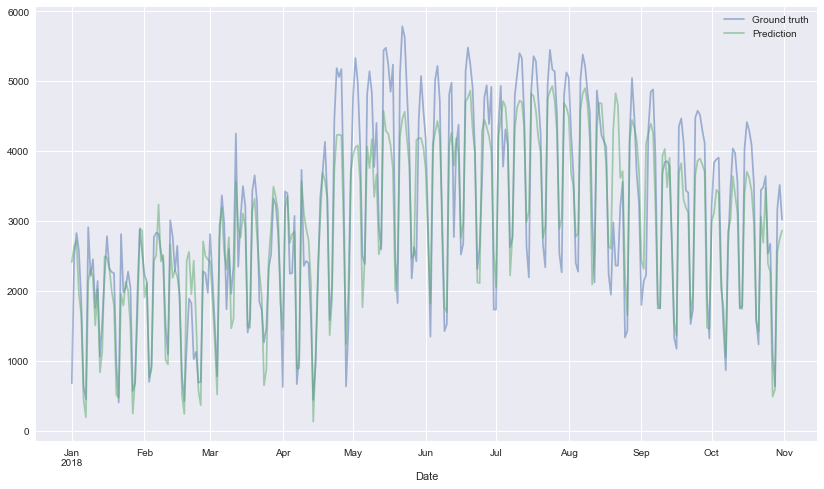

In [59]:
pd.DataFrame({"Ground truth": ytest, "Prediction": ypred}).plot(alpha=0.5);

It is evident that we have missed some key features, especially during the summer time. __Either our features are not complete__ (i.e., people decide whether to ride to work based on more than just these) or __there are some nonlinear relationships__ that we have failed to take into account (e.g., perhaps people ride less at both high and low temperatures).

Nevertheless, our rough approximation is enough to give us some insights, and we can __take a look at the coefficients of the linear model to estimate how much each feature contributes__ to the daily bicycle count:

In [60]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon              629.550957
Tue              794.615424
Wed              791.955032
Thu              634.809911
Fri              316.751883
Sat            -1014.589594
Sun            -1082.269507
holiday        -1139.539483
daylight_hrs     113.175346
PRCP             -26.785489
dry day          512.680871
Temp (C)          72.045667
annual            20.275123
dtype: float64

These numbers are difficult to interpret without __some measure of their uncertainty__. We can compute these uncertainties quickly using __bootstrap resamplings__ of the data:

In [61]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(Xtrain, ytrain)).coef_
              for i in range(1000)], 0)

In [62]:
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

              effect  error
Mon            630.0   72.0
Tue            795.0   70.0
Wed            792.0   70.0
Thu            635.0   72.0
Fri            317.0   68.0
Sat          -1015.0   68.0
Sun          -1082.0   67.0
holiday      -1140.0  149.0
daylight_hrs   113.0    7.0
PRCP           -27.0    2.0
dry day        513.0   27.0
Temp (C)        72.0    3.0
annual          20.0    8.0


In [63]:
model.score(Xtest, ytest)

0.8341310238156903

Our model is almost certainly __missing some relevant information__. For example, __nonlinear effects__ (such as effects of precipitation __and__ cold temperature) and __nonlinear trends__ within each variable (such as disinclination to ride at very cold and very hot temperatures) cannot be accounted for in this model. Additionally, we have thrown away some of the finer-grained information (such as the difference between a rainy morning and a rainy afternoon), and __we have ignored correlations between days__ (such as the possible effect of a rainy Tuesday on Wednesday's numbers, or the effect of an unexpected sunny day after a streak of rainy days). These are all potentially interesting effects, and you now have the tools to begin exploring them if you wish!

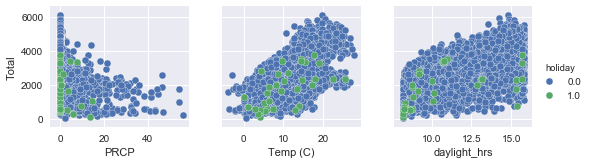

In [64]:
column_names = ['PRCP', 'Temp (C)', 'daylight_hrs', 'holiday']

sns.pairplot(X[column_names].join(y),size=2.5, hue="holiday", y_vars=['Total'], x_vars=['PRCP', 'Temp (C)', 'daylight_hrs']);

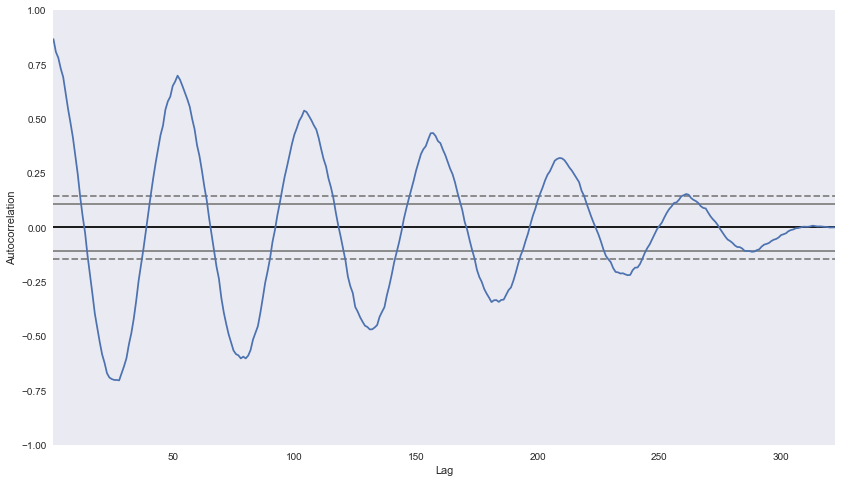

In [72]:
pd.plotting.autocorrelation_plot(y.resample('W').mean())

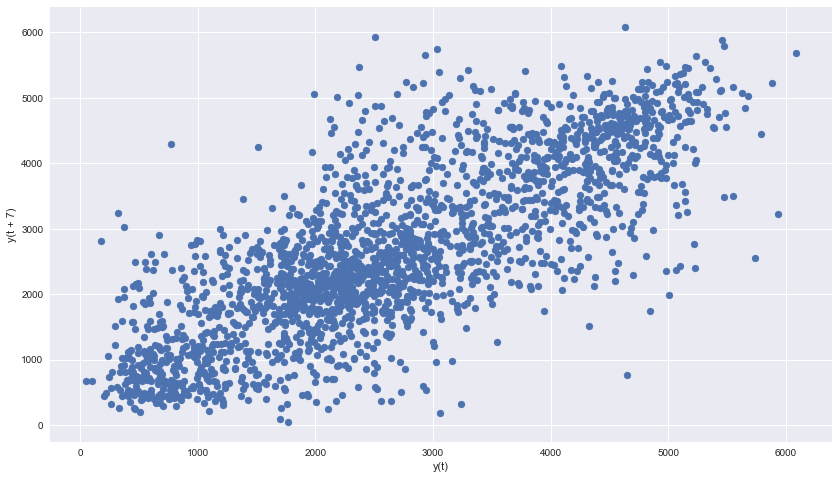

In [78]:
pd.plotting.lag_plot(y, lag=7)

In [ ]:
pd